In [2]:
# Libraries:
import pandas as pd
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
%pylab inline
import time
import joblib

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Config:
# In order to display all the columns:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 50

### FUNCTIONS

In [180]:
# Functions to put data in the correct format for estimation:
def get_set_tags(dataframe):
    # Use this function to get the set of tags in the document:
    user_tags=dataframe.usertag
    list_tags=[]
    for i in user_tags:
        for j in i.split(','):
            list_tags.append(j)
    set_tags=list(set(list_tags))
    return set_tags
# removing the null tags:
def remove_objects(list_values,obj="null"):
    return [x for x in list_values if x != obj]

# Functions to separate the usertag columns:
def create_tag_index_dictio(training_df,column="usertag",split_char=","):
    # Creates a dictionary with key: tag and value: list of rows
    tag_series=training_df[column].apply(lambda x:x.split(split_char))
    k=0
    tag_index={}
    for tags_line,index_tag in zip(tag_series,tag_series.index):
        k+=1
        for tag in tags_line:
            if tag != "null":
                if tag not in tag_index.keys():
                    tag_index[tag]=[index_tag]
                else:
                    tag_index[tag].append(index_tag)
        if k%1000000==0:
            print "%d completed"%(k)
    return tag_index

def get_tagsDF(dictio_tag_index,training_set):
    # Create the dictionary with key:usertag, value: list with 1 tha impression correspond to this tag 
    N=training_set.shape[0]
    dictio_tags_values={}
    for user_tag in dictio_tag_index.keys():
        sparce_array=[0]*N
        for i in dictio_tag_index[user_tag]:
            sparce_array[i]=1
        dictio_tags_values[user_tag]=sparce_array
    print "%d users completed, creating dataframe"%(len(dictio_tags_values.keys()))
    return pd.DataFrame(dictio_tags_values)

def normalize(dataframe,column="slotprice"):
    dataframe[column]=(dataframe[column]-dataframe[column].mean())/dataframe[column].std()
    



In [181]:
# Constants:

# According to the iPINyou paper:
columns_to_dummy=["weekday","hour","region","city","adexchange","slotwidth","slotheight","slotvisibility",
                  "slotformat"]
# For train and validation:
columns_to_drop=["bidid","logtype","userid","urlid","url","bidprice","payprice","keypage","creative","domain","IP","slotid"]
# For test:
#columns_to_drop=["bidid","logtype","userid","urlid","url","keypage","creative","domain","IP","slotid"]

### Importing datasets:

In [182]:
# Training set:
start_time=time.time()
filepath="../dataset/train.csv"  ### -----> put the path where is your file
#filepath="../dataset/validation.csv"
#filepath="../dataset/test.csv"
data=pd.read_csv(filepath)
print "data imported, num rows: %d, num cols: %d"%(data.shape[0],data.shape[1])


data imported, num rows: 2697738, num cols: 26


In [185]:
len(set(data.domain))

24087

In [189]:
x=data[0:100].iterrows()

In [192]:
next(x)

(2, click                                            0
 weekday                                          5
 hour                                             9
 bidid             2912cb5947e1fad450e2473c2f61ef75
 logtype                                          1
 userid                           u_VhkyORMrD8TP3GL
 useragent                               windows_ie
 IP                                    120.196.64.*
 region                                         216
 city                                           217
 adexchange                                       1
 domain                              trqRTJTxX5scg4
 url               845b72208c27b993daa11c8104449e22
 urlid                                         null
 slotid                mm_40135906_3486753_11388735
 slotwidth                                      336
 slotheight                                     280
 slotvisibility                                   0
 slotformat                                       1
 slotpric

In [ ]:
instance = {'weekday': row[1], 'hour': row[2], 'region': row[8], \
            'city': row[9], 'adexchange': row[10], 'slotwidth': row[15], 'slotheight': row[16], \
            'slotvisibility': row[17], 'slotformat': row[18], 'slotprice': float(row[19]) / STD_SLOTPRICE, \
            'advertiser': row[24]}

In [170]:
# validation set:
#filepath_val="../dataset/validation.csv"
#data_val=pd.read_csv(filepath_val)

#validation_set=data_val[data_val["bidprice"]>data_val["payprice"]]
#validation_set=validation_set.reset_index(drop=True)
#print "validation set: %d rows"%(validation_set.shape[0])

In [ ]:
def drop_inconsistent(data):
    if "bidprice" in data.columns:
        data=data[data["bidprice"]>data["payprice"]]
        return data.reset_index(drop=True)

In [171]:
# Droping inconsistent data:
training_set=data[data["bidprice"]>data["payprice"]]
training_set=training_set.reset_index(drop=True)
print "training set: %d rows"%(training_set.shape[0])

# Droping columns that we don't use:
training_set.drop(columns_to_drop, axis=1, inplace=True)
print "remaining cols: %d" % (training_set.shape[1])

training set: 2661039 rows
remaining cols: 14


In [172]:
# Getting the set of tags:
list_tags=get_set_tags(training_set)
list_tags=remove_objects(list_tags)

# creating dictionaries:
dictio_tag_index=create_tag_index_dictio(training_set)
dictio_os_browser=create_tag_index_dictio(training_set,"useragent","_")

# creating new dataframe:
N = training_set.shape[0]
tags_valuesDF=get_tagsDF(dictio_tag_index,training_set)
os_browserDF=get_tagsDF(dictio_os_browser,training_set)

500000 completed
1000000 completed
1500000 completed
2000000 completed
2500000 completed
500000 completed
1000000 completed
1500000 completed
2000000 completed
2500000 completed
68 users completed, creating dataframe
14 users completed, creating dataframe


In [162]:
# Creating categorical Variables:
training_set=pd.get_dummies(training_set,columns=columns_to_dummy)
normalize(training_set)

In [163]:
# Concatenating
clean_data = pd.concat([training_set, tags_valuesDF,os_browserDF], axis=1)
clean_data.drop(["useragent","usertag"],axis=1,inplace=True)

print("--- %s seconds ---" % (time.time() - start_time))

--- 115.260776997 seconds ---


In [4]:
del(data)
del(training_set)
clean_data.head()

NameError: name 'data' is not defined

In [155]:
import copy
clean_data1=copy.deepcopy(clean_data)

In [156]:
clean_data1.head()

,slotprice,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,region_0,region_1,region_2,region_3,region_15,region_27,region_40,region_55,region_65,region_79,region_80,region_94,region_106,region_124,region_134,region_146,region_164,region_183,...,10133,10138,10140,10142,10145,10146,10147,10148,10149,10684,11092,11278,11379,11423,11512,11576,11632,11680,11724,11944,13042,13403,13496,13678,13776,13800,13866,13874,14273,15398,16593,16617,16661,16706,16751,16753,android,chrome,firefox,ie,ios,linux,mac,maxthon,opera,other,safari,sogou,theworld,windows
0,-0.715301,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,1.451778,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,-0.173531,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,-0.715301,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0.124442,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


583

In [148]:
clean_data.drop(columns_to_drop, axis=1, inplace=True)

In [149]:
clean_data.shape

(299749, 583)

In [17]:
x_0=clean_data[clean_data.click==0]
x_1=clean_data[clean_data.click==1]

In [18]:
x_0.shape

(2659058, 584)

In [19]:
x_1.shape

(1981, 584)

In [15]:
X_train=np.array(clean_data)
X_train=X_train[:,1:]

In [16]:
X_train.shape

(2661039, 583)

In [116]:
from sklearn.decomposition import PCA
X = np.array(x_1)
X = X[:,1:]
pca = PCA(n_components=200)
pca.fit(X)


PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

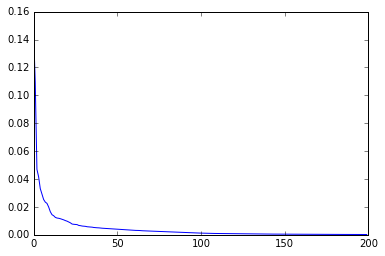

In [117]:
plt.plot(pca.explained_variance_ratio_)

In [118]:
pca_x1=pca.fit_transform(x_1)

In [119]:
pca_x1.shape

(1981, 200)

In [ ]:
# Saving file:
data_save = np.array(clean_data)

In [ ]:
joblib.dump(data_save, './data_for_CTR/full_data_val.pkl', compress=True)

In [ ]:
# Saving one file:
pd14=clean_data[clean_data.advertiser==1458].drop("advertiser",axis=1)
train14=np.array(pd14)
#np.save("data_train_1458",data_train_1458)

In [ ]:
train14=np.array(pd14)

In [ ]:
clean_train
joblib.dump(clean_train, './data_for_CTR/full_data.pkl', compress=True)

In [ ]:
#joblib.dump(train14, './data_for_CTR/val_data_1458.pkl', compress=True)

In [ ]:
#back14=joblib.load('test_dump.pkl')

In [ ]:
#pd14.to_csv("pd_14_val.csv",index=False)

In [ ]:
# Author: Matt Terry <matt.terry@gmail.com>
#
# License: BSD 3 clause
from __future__ import print_function

import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_footer
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_quoting
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


In [193]:


class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'length': len(text),
                 'num_sentences': text.count('.')}
                for text in posts]


class SubjectBodyExtractor(BaseEstimator, TransformerMixin):
    """Extract the subject & body from a usenet post in a single pass.

    Takes a sequence of strings and produces a dict of sequences.  Keys are
    `subject` and `body`.
    """
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        features = np.recarray(shape=(len(posts),),
                               dtype=[('subject', object), ('body', object)])
        for i, text in enumerate(posts):
            headers, _, bod = text.partition('\n\n')
            bod = strip_newsgroup_footer(bod)
            bod = strip_newsgroup_quoting(bod)
            features['body'][i] = bod

            prefix = 'Subject:'
            sub = ''
            for line in headers.split('\n'):
                if line.startswith(prefix):
                    sub = line[len(prefix):]
                    break
            features['subject'][i] = sub

        return features


pipeline = Pipeline([
    # Extract the subject & body
    ('subjectbody', SubjectBodyExtractor()),

    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('subject', Pipeline([
                ('selector', ItemSelector(key='subject')),
                ('tfidf', TfidfVectorizer(min_df=50)),
            ])),

            # Pipeline for standard bag-of-words model for body
            ('body_bow', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components=50)),
            ])),

            # Pipeline for pulling ad hoc features from post's body
            ('body_stats', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'subject': 0.8,
            'body_bow': 0.5,
            'body_stats': 1.0,
        },
    )),

    # Use a SVC classifier on the combined features
    ('svc', SVC(kernel='linear')),
])

# limit the list of categories to make running this example faster.
categories = ['alt.atheism', 'talk.religion.misc']
train = fetch_20newsgroups(random_state=1,
                           subset='train',
                           categories=categories,
                           )
test = fetch_20newsgroups(random_state=1,
                          subset='test',
                          categories=categories,
                          )

pipeline.fit(train.data, train.target)
y = pipeline.predict(test.data)
print(classification_report(y, test.target))

             precision    recall  f1-score   support

          0       0.64      0.80      0.71       256
          1       0.80      0.64      0.71       314

avg / total       0.73      0.71      0.71       570

